# The Professionalisation of Airbnb

## Front Matter
__Module Name:__ Introduction to Programming for Spatial Analysts \
__Module Number:__ CASA0013 \
__Student Number:__ 15043876 

## Executive Briefing

With the government’s crackdown on the private rented sector putting some landlords off, Airbnb and similar short-term letting options can provide a lucrative alternative.

## Reproducible Analysis

In [5]:
# Load all the packages that will be used
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [7]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [9]:
# Read the raw data and save it locally
ddir  = os.path.join('data','raw') # destination directory
path = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

# read the csv
listings = pd.read_csv( cache_data(path+'2020-08-24-listings.csv.gz?raw=true', ddir),
    compression='gzip', low_memory=False)

# print dataframe
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Found data/raw/2020-08-24-listings.csv.gz locally!
Data frame is 74,188 x 74


In [10]:
del(listings)

In [22]:
# Lets just look at the columns we're interested in
cols = ['id','price','latitude','longitude',
        'host_id','host_name','host_since','property_type','room_type',
        'accommodates','number_of_reviews','availability_365','calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms']

listings  = pd.read_csv("data/raw/2020-08-24-listings.csv.gz",usecols=cols,low_memory=False)

print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 74,188 x 16


In [21]:
#have a look at the data
listings.head()

,id,host_id,host_name,host_since,latitude,longitude,property_type,room_type,accommodates,price,availability_365,number_of_reviews,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,11551.0,43039.0,Adriano,2009-10-03,51.46225,-0.11732,Entire apartment,Entire home/apt,4.0,$87.00,236.0,192,2.0,2.0,0.0,0.0
1,13913.0,54730.0,Alina,2009-11-16,51.56802,-0.11121,Private room in apartment,Private room,2.0,$49.00,364.0,21,3.0,1.0,2.0,0.0
2,15400.0,60302.0,Philippa,2009-12-05,51.48796,-0.16898,Entire apartment,Entire home/apt,2.0,$75.00,359.0,89,1.0,1.0,0.0,0.0
3,17402.0,67564.0,Liz,2010-01-04,51.52195,-0.14094,Entire apartment,Entire home/apt,6.0,$208.00,1.0,42,14.0,14.0,0.0,0.0
4,17506.0,67915.0,Charlotte,2010-01-05,51.47935,-0.19743,Private room in bed and breakfast,Private room,2.0,$150.00,364.0,0,2.0,0.0,2.0,0.0


### Let's first look at all the properties currently listed in London
We will want to load some geodata on which we can map our listings. Here we will download and save a geopackage for the London Boroughs shapefile. Available from the London datastore

In [50]:
data.to_file("data/geo/boroughs.gpkg", driver="GPKG")

In [53]:
directory = os.path.join('data','geo') # destination directory
spath = "https://github.com/signesw/i2p_coursework/blob/main/data/geo/boroughs.gpkg?raw=true" # source path

London = gpd.read_file( cache_data(spath, directory) ) # reading and saving file locally if not already there

Found data/geo/boroughs.gpkg locally!


Let's have a look at the map, just to check the geopackage has been loaded correctly

<AxesSubplot:>

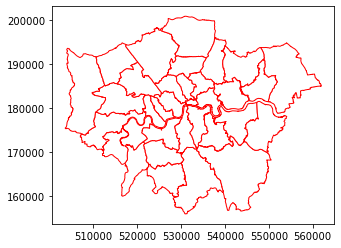

In [59]:
# Let's reproject into OSGB36
London = London.to_crs('EPSG:27700')

London.plot(edgecolor="red", facecolor="white", linewidth=1)


Now we want to plot our airbnb points onto the map - let's have a look at how to do this.
the listings data has longitude and latitude coordinates, coordinates, so we can convert our data to a geodataframe

In [64]:
#we want to drop the rows where longitude and latitude are na values, as this will cause issues when converting to dataframe
listings.drop(listings[listings.latitude.isna()].index.values, axis=0, inplace=True)
listings.drop(listings[listings.longitude.isna()].index.values, axis=0, inplace=True)
print(f"listings dataframe now contains {pdf.shape[0]} rows.")

listings dataframe now contains 74188 rows.


In [67]:
listings.head()

,id,host_id,host_name,host_since,latitude,longitude,property_type,room_type,accommodates,price,availability_365,number_of_reviews,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,11551.0,43039.0,Adriano,2009-10-03,51.46225,-0.11732,Entire apartment,Entire home/apt,4.0,$87.00,236.0,192,2.0,2.0,0.0,0.0
1,13913.0,54730.0,Alina,2009-11-16,51.56802,-0.11121,Private room in apartment,Private room,2.0,$49.00,364.0,21,3.0,1.0,2.0,0.0
2,15400.0,60302.0,Philippa,2009-12-05,51.48796,-0.16898,Entire apartment,Entire home/apt,2.0,$75.00,359.0,89,1.0,1.0,0.0,0.0
3,17402.0,67564.0,Liz,2010-01-04,51.52195,-0.14094,Entire apartment,Entire home/apt,6.0,$208.00,1.0,42,14.0,14.0,0.0,0.0
4,17506.0,67915.0,Charlotte,2010-01-05,51.47935,-0.19743,Private room in bed and breakfast,Private room,2.0,$150.00,364.0,0,2.0,0.0,2.0,0.0


In [70]:
# turning our lsitings data to geodata using long and lat and saving locally as geopackage

listings_geo = gpd.GeoDataFrame(listings, 
      geometry=gpd.points_from_xy(listings['longitude'], listings['latitude'], crs='epsg:4326'))

listings_geo.to_file('data/geo/listings.gpkg', driver="GPKG")

In [78]:
# check crs and reproject

print(listings_geo.geometry.crs)
listings_geo=listings_geo.to_crs('EPSG:27700')
print(listings_geo.geometry.crs)

EPSG:27700
EPSG:27700


(155000.0, 202000.0)

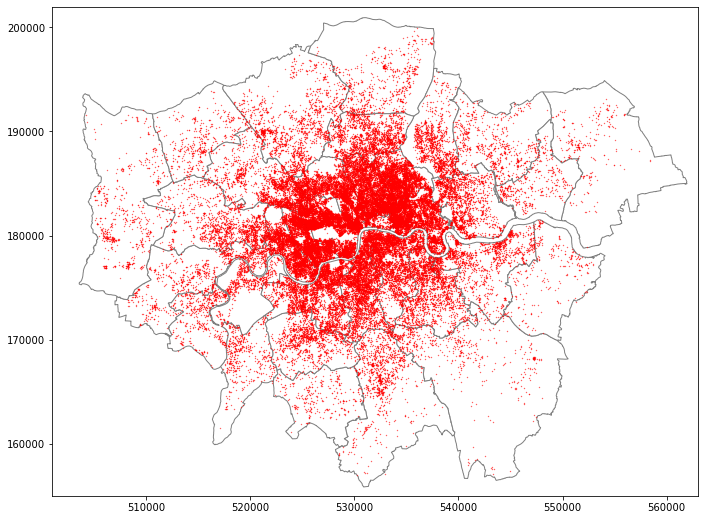

In [84]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three to the same axes
London.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
listings_geo.plot(ax=ax,color="red", alpha=0.9, markersize=0.1)

# Set the limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)
